# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
from sqlalchemy import create_engine
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import re
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [2]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BOluga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BOluga\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# load data from database

def load_data():
    engine = create_engine('sqlite:///data/DisasterResponse.db')
    sql = 'SELECT * from messages_and_categories;'
    df = pd.read_sql(sql, engine)
    
    print("Loaded data {} rows by {} columns.".format(df.shape[0], df.shape[1]))
    print('*' * 65)
    print('{0:25}{1:>20}{2:>20}'.format('COLUMN', 'TOTAL NO. OF NULLS', 'NULLS (%)'))
    
    for col in df.isnull().sum().keys():
        print('{0:25}{1:>20}{2:>20.2f}'.format(col, df.isnull().sum()[col], df.isnull().sum()[col]*100/df.shape[0]))
    
    df.drop(df[df['related'] == 2].index, inplace = True)
    df.drop(columns=['original'], inplace = True)

    print('*' * 65)
    print("Only the 'original' column has nulls, but it's not used. It's safe to delete.")

    print('*' * 65)
    print("Dropping {} 'related' rows with values as 2.".format(df[df['related'] == 2].shape[0]))
    
    print('*' * 65)
    print("Loaded data now has {} rows by {} columns.".format(df.shape[0], df.shape[1]))
    
    X = df['message']
    y = df[['related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'child_alone', 'water', 'food', 'shelter',
       'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report']]

    return X, y, df

In [4]:
X, y, df = load_data()
X.sample(5)

Loaded data 26216 rows by 40 columns.
*****************************************************************
COLUMN                     TOTAL NO. OF NULLS           NULLS (%)
id                                          0                0.00
message                                     0                0.00
original                                16046               61.21
genre                                       0                0.00
related                                     0                0.00
request                                     0                0.00
offer                                       0                0.00
aid_related                                 0                0.00
medical_help                                0                0.00
medical_products                            0                0.00
search_and_rescue                           0                0.00
security                                    0                0.00
military                              

17008    Despite the potential shift of attention to ca...
15565    The death toll from Mount Merapi's ongoing eru...
1675     My friends hello please dont forget us we cann...
7007     Look at the example of the French West Indies ...
1146     Hello, good evening. I'm wondering what a pers...
Name: message, dtype: object

In [5]:
y.sample(5)

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
1082,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11843,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
9833,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12714,1,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,1
8899,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
df['related'].unique()

array([1, 0], dtype=int64)

In [7]:
df[df['related']==2]

,id,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report


### 2. Write a tokenization function to process your text data

In [8]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def tokenize(text):
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = [lemmatizer.lemmatize(token).lower().strip() for token in tokens]

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [9]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('knn_clf', MultiOutputClassifier(KNeighborsClassifier()))
])

knn_est_params = {
    #'knn_clf__estimator__algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'knn_clf__estimator__n_neighbors': [5, 10, 15],
    'knn_clf__estimator__weights': ['uniform', 'distance'],
    #'knn_clf__metric': ['euclidian', 'manhattan']
}

cv = GridSearchCV(pipeline, param_grid=knn_est_params)


In [10]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('knn_clf', MultiOutputClassifier(KNeighborsClassifier()))
])
# sorted(pipeline.get_params().keys())

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [11]:
def display_results(cv, y_test, y_pred):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)
    print("\nBest Parameters:", cv.best_params_)

In [12]:
import time

start = time.time()

print('loading data')
X, y, df = load_data()
print("Runtime of the program is {}".format(time.time()-start))
print('*'*80)

print('splitting data')
X_train, X_test, y_train, y_test = train_test_split(X, y)
print("Runtime of the program is {}".format(time.time()-start))
print('*'*80)

print('fitting data')
cv.fit(X_train, y_train)
print("Runtime of the program is {}".format(time.time()-start))
print('*'*80)

print('getting y-pred')
y_pred = cv.predict(X_test)
print("Runtime of the program is {}".format(time.time()-start))
print('*'*80)


loading data
Loaded data 26216 rows by 40 columns.
*****************************************************************
COLUMN                     TOTAL NO. OF NULLS           NULLS (%)
id                                          0                0.00
message                                     0                0.00
original                                16046               61.21
genre                                       0                0.00
related                                     0                0.00
request                                     0                0.00
offer                                       0                0.00
aid_related                                 0                0.00
medical_help                                0                0.00
medical_products                            0                0.00
search_and_rescue                           0                0.00
security                                    0                0.00
military                 

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [13]:
print('RESULTS')
labels = np.unique(y_pred)
# confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
# accuracy = (y_pred == y_test).mean()

print("Labels:", labels)
# print("Confusion Matrix:\n", confusion_mat)
# print("Accuracy:", accuracy)
print("\nBest Parameters:", cv.best_params_)
print("Runtime of the program is {}".format(time.time()-start))
print('*'*80)

RESULTS
Labels: [0 1]

Best Parameters: {'knn_clf__estimator__n_neighbors': 10, 'knn_clf__estimator__weights': 'uniform'}
Runtime of the program is 3968.0445680618286
********************************************************************************


In [44]:
var_cols = ['related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'child_alone', 'water', 'food', 'shelter',
       'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report']
y_pred_df = pd.DataFrame(y_pred, columns=var_cols)

In [48]:
accuracy = round((y_pred == y_test).mean()*100, 2)
accuracy

related                    79.58
request                    89.41
offer                      99.55
aid_related                70.94
medical_help               89.13
medical_products           93.21
search_and_rescue          97.10
security                   97.99
military                   96.59
child_alone               100.00
water                      93.22
food                       88.64
shelter                    89.26
clothing                   98.52
money                      97.99
missing_people             98.83
refugees                   96.47
death                      94.16
other_aid                  86.84
infrastructure_related     93.28
transport                  95.02
buildings                  94.59
electricity                98.11
tools                      99.28
hospitals                  98.89
shops                      99.48
aid_centers                98.85
other_infrastructure       95.64
weather_related            79.36
floods                     90.07
storm     

In [19]:
y_pred_df

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6502,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6503,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6504,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6505,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
y_test

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
25206,1,1,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1120,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8207,1,1,0,1,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
10942,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14994,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3610,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13625,1,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2694,1,1,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
17994,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
import random
n = random.randint(0, len(plt.colormaps()))
print(plt.colormaps()[n])

Pastel2


Confusion Matrix, Precision, Recall, and Accuracy


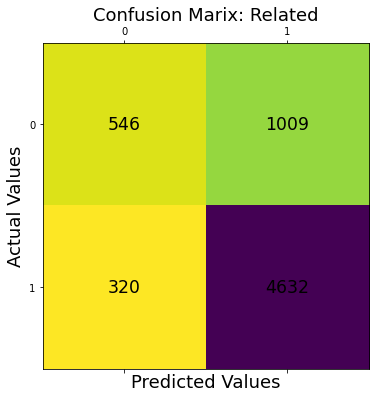

Precision: 0.821
Recall: 0.935
Accuracy: 0.796
F1 Score: 0.875


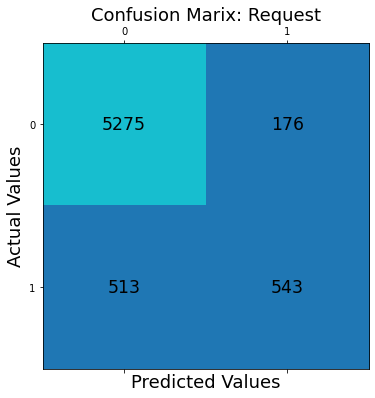

Precision: 0.755
Recall: 0.514
Accuracy: 0.894
F1 Score: 0.612


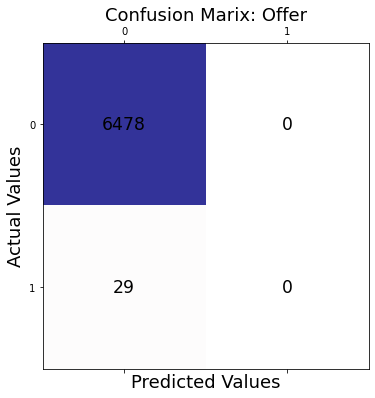

Precision: 0.000
Recall: 0.000
Accuracy: 0.996
F1 Score: 0.000


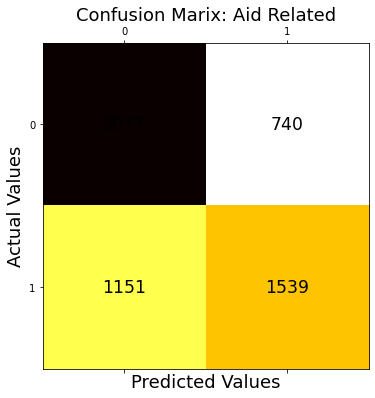

Precision: 0.675
Recall: 0.572
Accuracy: 0.709
F1 Score: 0.619


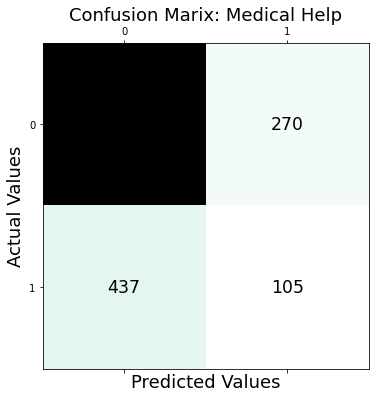

Precision: 0.280
Recall: 0.194
Accuracy: 0.891
F1 Score: 0.229


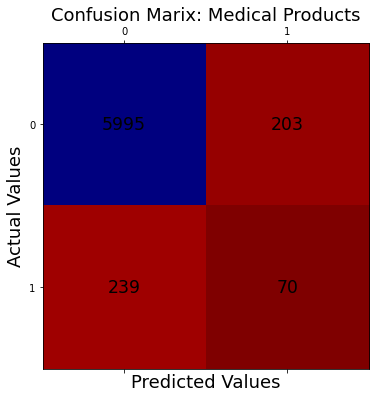

Precision: 0.256
Recall: 0.227
Accuracy: 0.932
F1 Score: 0.241


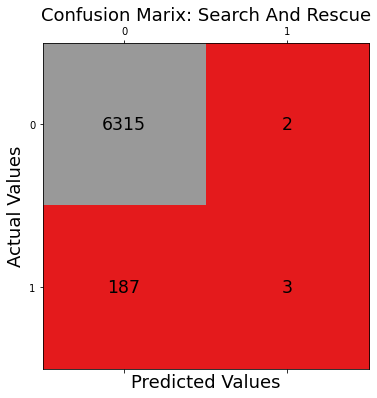

Precision: 0.600
Recall: 0.016
Accuracy: 0.971
F1 Score: 0.031


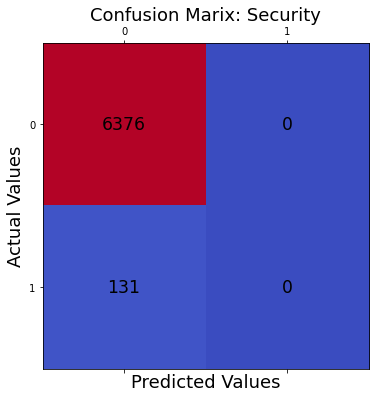

Precision: 0.000
Recall: 0.000
Accuracy: 0.980
F1 Score: 0.000


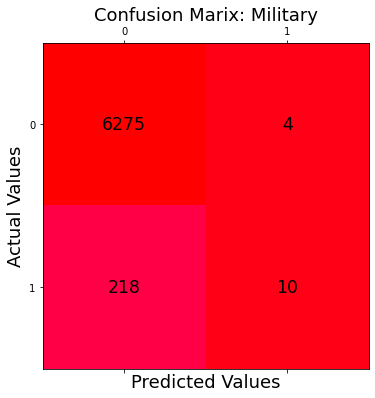

Precision: 0.714
Recall: 0.044
Accuracy: 0.966
F1 Score: 0.083


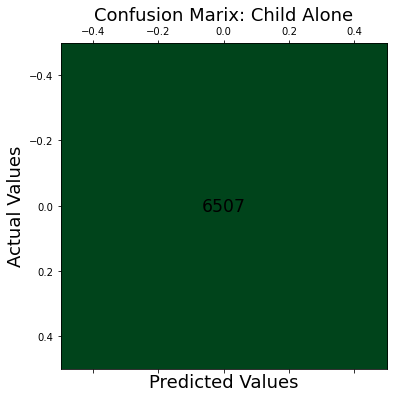

Precision: 0.000
Recall: 0.000
Accuracy: 1.000
F1 Score: 0.000


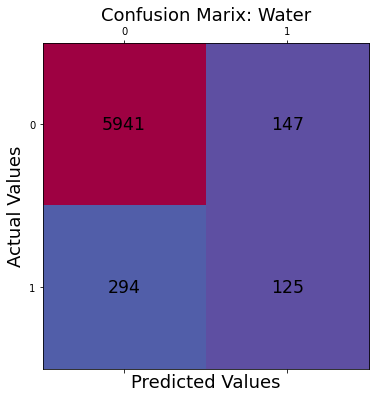

Precision: 0.460
Recall: 0.298
Accuracy: 0.932
F1 Score: 0.362


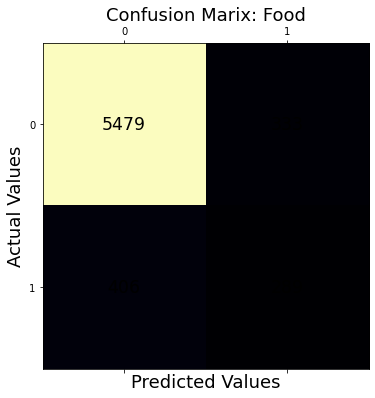

Precision: 0.465
Recall: 0.416
Accuracy: 0.886
F1 Score: 0.439


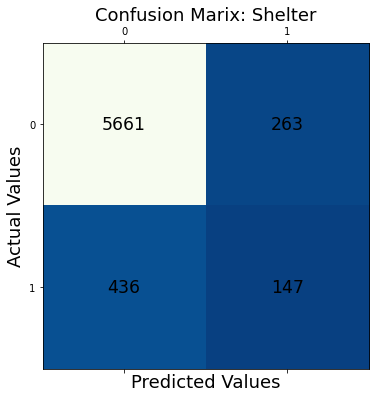

Precision: 0.359
Recall: 0.252
Accuracy: 0.893
F1 Score: 0.296


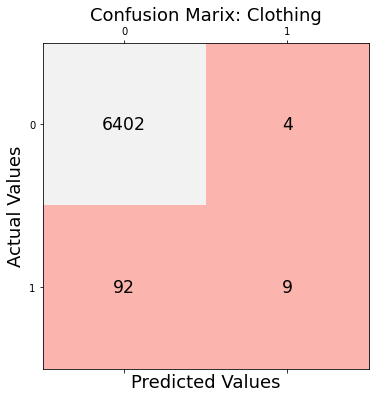

Precision: 0.692
Recall: 0.089
Accuracy: 0.985
F1 Score: 0.158


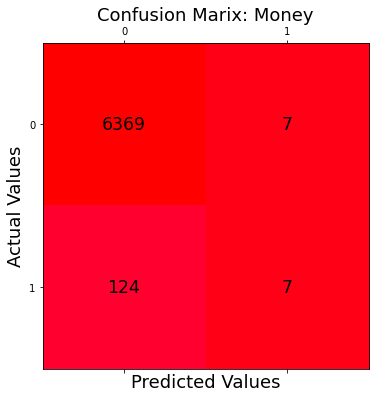

Precision: 0.500
Recall: 0.053
Accuracy: 0.980
F1 Score: 0.097


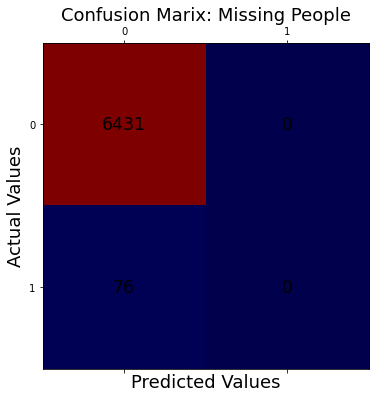

Precision: 0.000
Recall: 0.000
Accuracy: 0.988
F1 Score: 0.000


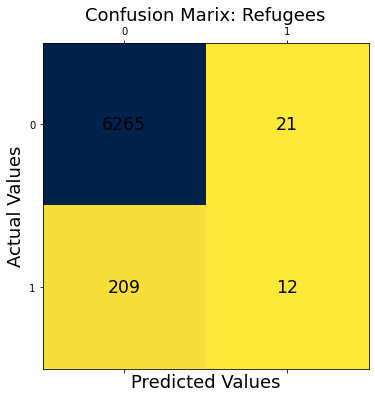

Precision: 0.364
Recall: 0.054
Accuracy: 0.965
F1 Score: 0.094


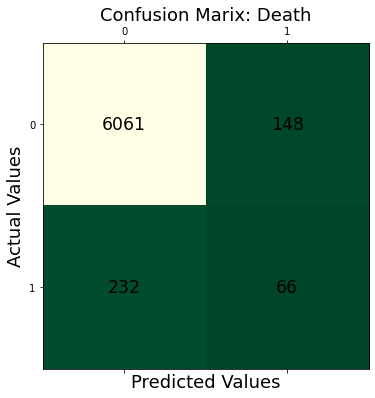

Precision: 0.308
Recall: 0.221
Accuracy: 0.942
F1 Score: 0.258


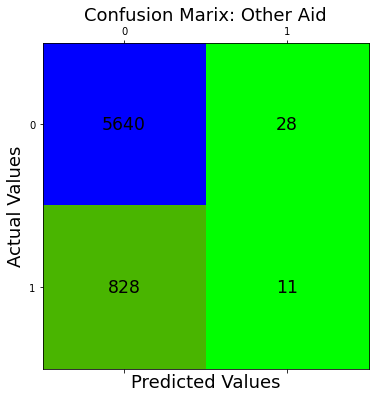

Precision: 0.282
Recall: 0.013
Accuracy: 0.868
F1 Score: 0.025


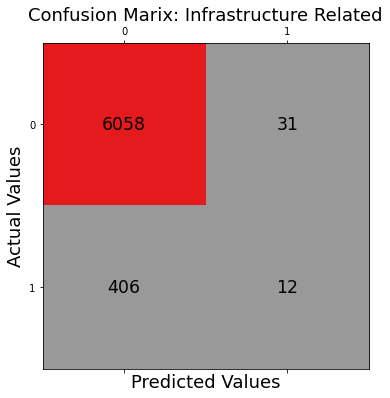

Precision: 0.279
Recall: 0.029
Accuracy: 0.933
F1 Score: 0.052


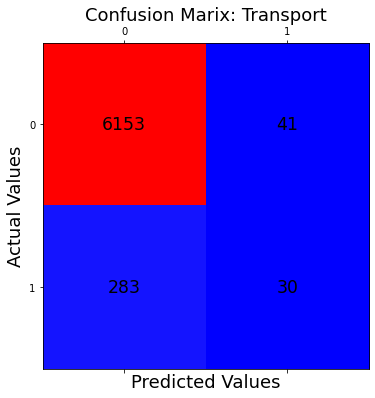

Precision: 0.423
Recall: 0.096
Accuracy: 0.950
F1 Score: 0.156


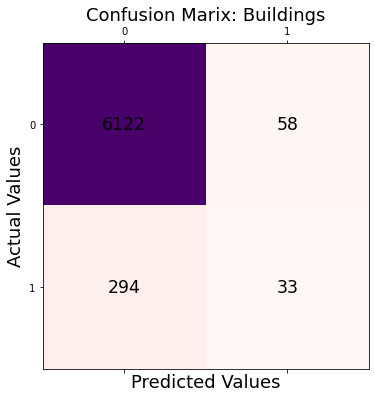

Precision: 0.363
Recall: 0.101
Accuracy: 0.946
F1 Score: 0.158


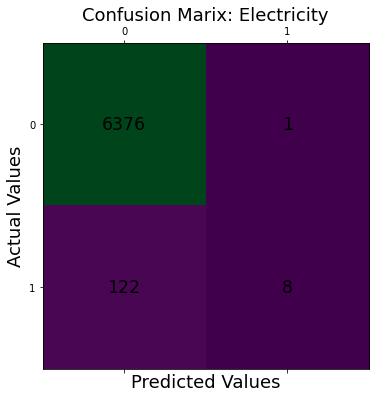

Precision: 0.889
Recall: 0.062
Accuracy: 0.981
F1 Score: 0.115


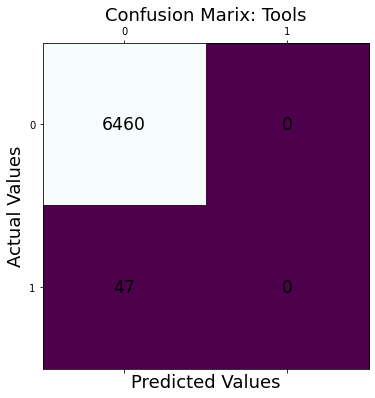

Precision: 0.000
Recall: 0.000
Accuracy: 0.993
F1 Score: 0.000


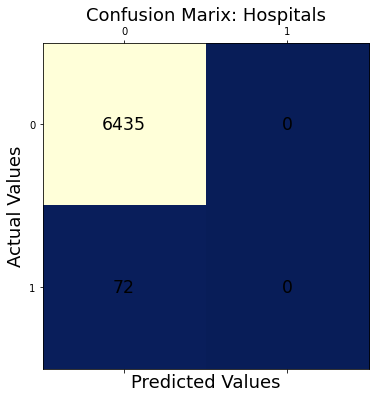

Precision: 0.000
Recall: 0.000
Accuracy: 0.989
F1 Score: 0.000


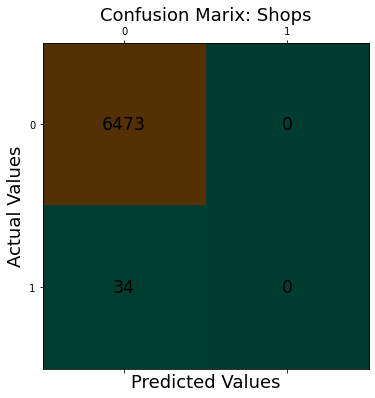

Precision: 0.000
Recall: 0.000
Accuracy: 0.995
F1 Score: 0.000


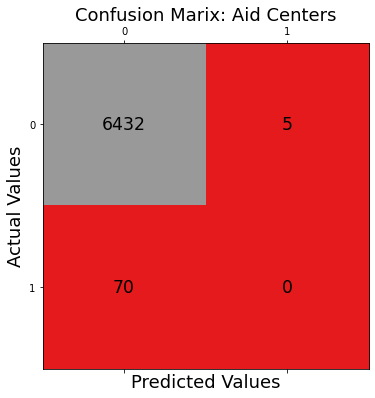

Precision: 0.000
Recall: 0.000
Accuracy: 0.988
F1 Score: 0.000


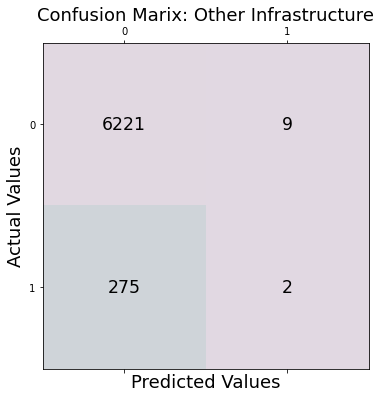

Precision: 0.182
Recall: 0.007
Accuracy: 0.956
F1 Score: 0.014


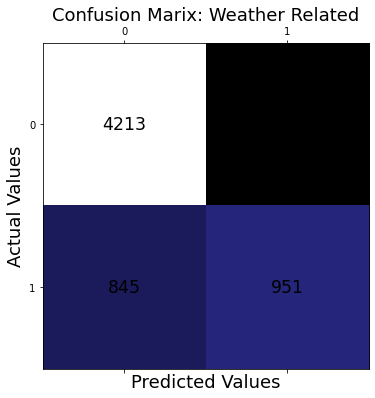

Precision: 0.656
Recall: 0.530
Accuracy: 0.794
F1 Score: 0.586


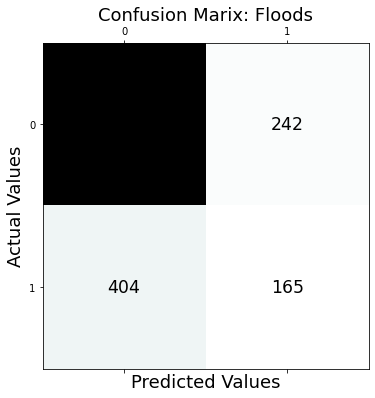

Precision: 0.405
Recall: 0.290
Accuracy: 0.901
F1 Score: 0.338


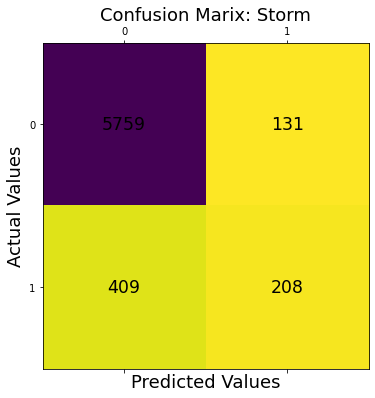

Precision: 0.614
Recall: 0.337
Accuracy: 0.917
F1 Score: 0.435


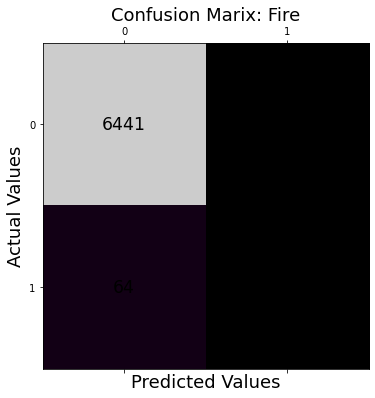

Precision: 1.000
Recall: 0.030
Accuracy: 0.990
F1 Score: 0.059


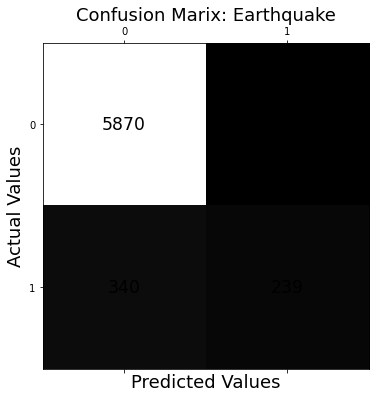

Precision: 0.805
Recall: 0.413
Accuracy: 0.939
F1 Score: 0.546


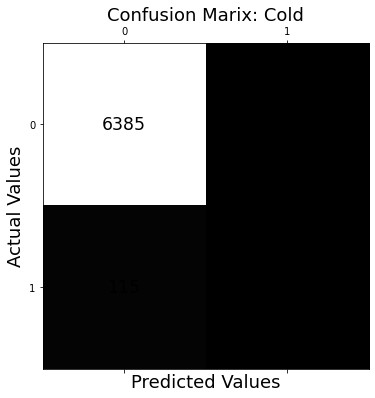

Precision: 0.857
Recall: 0.050
Accuracy: 0.982
F1 Score: 0.094


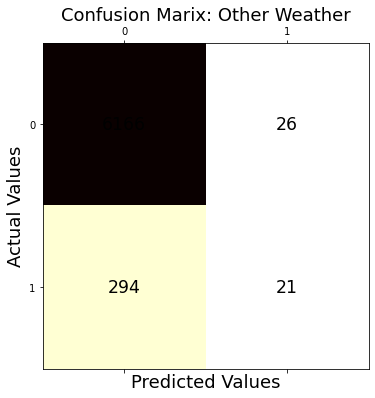

Precision: 0.447
Recall: 0.067
Accuracy: 0.951
F1 Score: 0.116


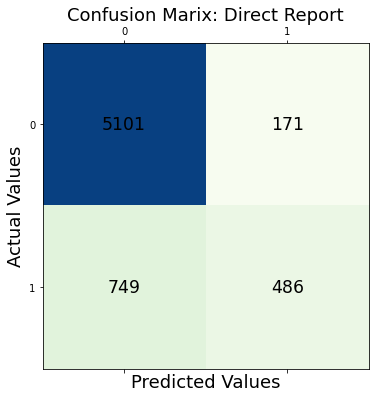

Precision: 0.740
Recall: 0.394
Accuracy: 0.859
F1 Score: 0.514


In [101]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt


print('Confusion Matrix, Precision, Recall, and Accuracy')

for col in var_cols:
    n = random.randint(0, len(plt.colormaps()))
    cmap = plt.colormaps()[n]
    # print(cmap)
    conf_matrix = confusion_matrix(y_true=y_test[col], y_pred=y_pred_df[col])
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.matshow(conf_matrix, cmap=cmap)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predicted Values', fontsize=18)
    plt.ylabel('Actual Values', fontsize=18)
    plt.title('Confusion Marix: ' + col.replace('_', ' ').title(), fontsize=18)
    plot_name = './graphs/matrix_' + col + '.png'
    plt.savefig(plot_name)
    plt.show()
    print('Precision: %.3f' % precision_score(y_test[col], y_pred_df[col]))
    print('Recall: %.3f' % recall_score(y_test[col], y_pred_df[col]))
    print('Accuracy: %.3f' % accuracy_score(y_test[col], y_pred_df[col]))
    print('F1 Score: %.3f' % f1_score(y_test[col], y_pred_df[col]))

### 6. Improve your model
Use grid search to find better parameters. 

In [16]:
parameters = 

cv = 

SyntaxError: invalid syntax (<ipython-input-16-1e622dfcf28d>, line 1)

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

In [102]:
import pickle
# save the model to disk
filename = './models/finalized_model.web.pickle'
pickle.dump(cv, open(filename, 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

## Plotting

In [ ]:
df.sample()

In [ ]:
df['genre'].unique()

In [ ]:
df['genre'].value_counts().plot(kind='barh');

In [ ]:
sub_cols=['related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'child_alone', 'water', 'food', 'shelter',
       'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report']

sub_cols.sort()
print(sub_cols)

In [ ]:
import math
import matplotlib.pyplot as plt

i, j = 0, 0
PLOTS_PER_ROW = 3
fig, axs = plt.subplots(math.ceil(len(sub_cols) / PLOTS_PER_ROW), PLOTS_PER_ROW, figsize=(15, 30))
fig.tight_layout()
for col in sub_cols:
    #axs[i][j].scatter(df['target_col'], df[col], s=3)
    (df[col].value_counts(normalize=True)*100).sort_values().plot(kind='barh', ax=axs[i][j])
    axs[i][j].set_title(col.replace('_', ' ').title())
    axs[i][j].set_xlim(xmin=0, xmax=100)
    j += 1
    if j % PLOTS_PER_ROW == 0:
        i += 1
        j = 0
plt.show()

In [ ]:
(df['related'].value_counts(normalize=True)*100).sort_values()